## Natural Language Processing and Time Series Data

Training a computer to understand written/spoken word is perhaps a less useful tool for physics and astronomy, but does fit in well with the "social sciences," and is a useful tool. More generally, the ability to use relations in sequential data is a tool that pops up a lot in astronomy and physics, think for example a detector in a telescope.

Below partially borrowed from Josh Blooms lectures.

# Text Data

Many applications involve parsing and understanding something about natural language, ie. speech or text data.  Categorization is a classic usage of Natural Language Processing (NLP): what bucket does this text belong to? 


A classic dataset in text processing is the [20,000+ newsgroup documents corpus](http://qwone.com/~jason/20Newsgroups/). These texts taken from old discussion threads in 20 different [newgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup), these are online discussion threads dating back to early days of the internet...

<pre>
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x	
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey	
sci.crypt
sci.electronics
sci.med
sci.space
misc.forsale	
talk.politics.misc
talk.politics.guns
talk.politics.mideast	
talk.religion.misc
alt.atheism
soc.religion.christian
</pre>
One of the tasks is to assign a document to the correct group, ie. classify which group this belongs to. `sklearn` has a download facility for this dataset:

In [1]:
from sklearn.datasets import fetch_20newsgroups
news_train = fetch_20newsgroups(subset='train', categories=['sci.space','rec.autos'], data_home='datatmp/')

In [2]:
news_train.target_names

['rec.autos', 'sci.space']

In [3]:
#we want to take this data and figure out which newsgroup it belongs to...

print(news_train.data[20])

From: c23tvr@kocrsv01.delcoelect.com (Thomas Redmond)
Subject: Re: $6700 for hail damage - a record?
Originator: c23tvr@koptsy17
Organization: Delco Electronics Corp.
Distribution: usa
Lines: 34


In article <1993Apr21.053516.28846@cactus.org>, boyle@cactus.org (Craig Boyle) writes:
> In article <1993Apr20.203219.7724@pencom.com> stecz@pencom.com writes:
> >In article <1993Apr19.235711.7285@cactus.org> boyle@cactus.org (Craig Boyle)  
> >writes:
> >> 
> >> 
> >> My 90 Integra was hit hard in the 3/25 hailstorm in Austin, TX. 
> >> The insurance company cut me a check for $6600 ($100 deductible)
> >> last week.  Is this a record? Anybody else had settlements from
> >> the same hailstorm yet?
> >> 
> >> Craig
> >
> >
> >Rumor has it that a guy at Dell Computer had his Miata totalled, so that would  
> >be about $10k.
> 
> I guess it either had the top down, or the hail ripped through the top, as
> you could not do $10k worth of hail damage to a Miata body. 
> 
> Craig
> >
> >
> >--
> >--

In [4]:
print(news_train.target_names[news_train.target[20]])

rec.autos


In [5]:
%pylab inline

autos = np.argwhere(news_train.target == 1) 
sci = np.argwhere(news_train.target == 0)

Populating the interactive namespace from numpy and matplotlib


**How do you (as a human) classify text? What do you look for? How might we make these features?**

In [6]:
print(news_train.data[autos[3][0]])

From: pgf@srl03.cacs.usl.edu (Phil G. Fraering)
Subject: Re: Griffin / Office of Exploration: RIP
Organization: Univ. of Southwestern Louisiana
Lines: 43

yamauchi@ces.cwru.edu (Brian Yamauchi) writes:

>Any comments on the absorbtion of the Office of Exploration into the
>Office of Space Sciences and the reassignment of Griffin to the "Chief
>Engineer" position?  Is this just a meaningless administrative
>shuffle, or does this bode ill for SEI?

>In my opinion, this seems like a Bad Thing, at least on the surface.
>Griffin seemed to be someone who was actually interested in getting
>things done, and who was willing to look an innovative approaches to
>getting things done faster, better, and cheaper.  It's unclear to me
>whether he will be able to do this at his new position.

>Does anyone know what his new duties will be?

First I've heard of it. Offhand:

Griffin is no longer an "office" head, so that's bad.

On the other hand:

Regress seemed to think: we can't fund anything by Grif

In [7]:
# total character count?
f1 = np.array([len(x) for x in news_train.data])
f1

array([ 676,  910,  756, ..., 1433,  413,  602])

Text(0.5, 0, 'number of charaters')

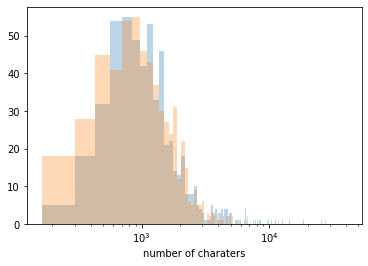

In [8]:
_,bins,_ = plt.hist(f1[autos], bins=300,label = "autos",alpha = .3)
plt.hist(f1[sci],bins=bins, label= "sci",alpha = .3)
plt.xscale("log")
plt.xlabel("number of charaters")

In [9]:
#Not so useful...

In [10]:
# total character words?
f2 = np.array([len(x.split(" ")) for x in news_train.data])
f2

array([112, 130, 110, ..., 205,  59,  79])

Text(0.5, 0, 'number of words')

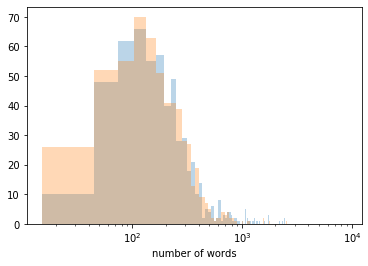

In [11]:
_,bins,_ = plt.hist(f2[autos], bins=300,label = "autos",alpha = .3)
plt.hist(f2[sci],bins=bins, label= "sci",alpha = .3)
plt.xscale("log")
plt.xlabel("number of words")

In [12]:
# number of questions asked or exclaimations?
f3 = np.array([x.count("?") + x.count("!") for x in news_train.data])
f3

array([4, 5, 4, ..., 2, 1, 0])

Text(0.5, 0, 'number of exclamation points')

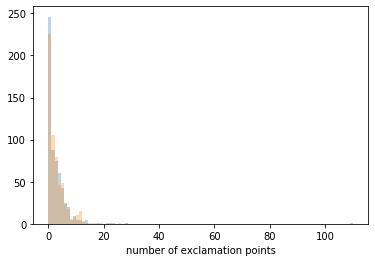

In [13]:
_,bins,_ = plt.hist(f3[autos], bins=100,label = "autos",alpha = .3)
plt.hist(f3[sci],bins=bins, label= "sci",alpha = .3)
#plt.xscale("log")
plt.xlabel("number of exclamation points")

We've got three fairly uninformative features now. We should be able to do better. 
Unsurprisingly, what matters most in NLP is the content: the words used, the tone, the meaning from the ordering of those words. The basic components of NLP are:

 * Tokenization - intelligently splitting up words in sentences, paying attention to conjunctions, punctuation, etc.
 * Lemmization - reducing a word to its base form
 * Entity recognition - finding proper names, places, etc. in documents
 
There a many Python packages that help with NLP, including `nltk`, `textblob`, `gensim`, etc. Here we'll use the fairly modern and battletested [`spaCy`](https://spacy.io/).

In [14]:
#!pip install spacy
#!python3 -m spacy download en

In [16]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en")

# the spanish model is
# nlp = spacy.load("es")

doc = nlp(u"Guido said that 'Python is one of the best languages for doing Data Science.' "
                   "Why he said that should be clear to anyone who knows Python.")
en_doc = doc

`doc` is now an `iterable ` with each word/item properly tokenized and tagged.  This is done by applying rules specific to each language.  Linguistic annotations are available as Token attributes.

In [17]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Guido Guido PROPN NNP nsubj Xxxxx True False
said say VERB VBD ROOT xxxx True False
that that ADP IN mark xxxx True True
' ' PUNCT `` punct ' False False
Python Python PROPN NNP nsubj Xxxxx True False
is be VERB VBZ ccomp xx True True
one one NUM CD attr xxx True True
of of ADP IN prep xx True True
the the DET DT det xxx True True
best good ADJ JJS amod xxxx True False
languages language NOUN NNS pobj xxxx True False
for for ADP IN prep xxx True True
doing do VERB VBG pcomp xxxx True True
Data Data PROPN NNP compound Xxxx True False
Science Science PROPN NNP dobj Xxxxx True False
. . PUNCT . punct . False False
' ' PUNCT '' punct ' False False
Why why ADV WRB advmod Xxx True True
he -PRON- PRON PRP nsubj xx True True
said say VERB VBD ROOT xxxx True False
that that DET DT nsubj xxxx True True
should should VERB MD aux xxxx True True
be be VERB VB ccomp xx True True
clear clear ADJ JJ acomp xxxx True False
to to ADP IN prep xx True True
anyone anyone NOUN NN pobj xxxx True True
who who 

One very powerful way to featurize text/documents is to count the frequency of words---this is called **bag of words**. Each individual token occurrence frequency is used to generate a feature. So the two sentences become:

```json
{"Guido": 1,
  "said": 2,
  "that": 2,
  "Python": 2,
  "is": 1,
  "one": 1,
  "of": 1,
  "best": 1,
  "languages": 1,
  "for": 1,
  "Data": 1,
  "Science": 1,
  "Why", 1,
  "he": 1,
  "should": 1,
  "be": 1,
  "anyone": 1,
  "who": 1
 }
 ```


A corpus of documents can be represented as a matrix with one row per document and one column per token.

Question: **What are some challenges you see with brute force BoW?**

In [18]:
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

`sklearn` has a number of helper functions, include the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

> Convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using `scipy.sparse.csr_matrix`.

In [19]:
# the following is from https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [20]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [21]:
X = bow_vector.fit_transform([x.text for x in en_doc.sents])

In [22]:
X

<2x7 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [23]:
bow_vector.get_feature_names()

['clear', 'datum', 'guido', 'know', 'language', 'python', 'science']

Why did we get `datum` as one of our feature names?

In [24]:
X.toarray()

array([[0, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 0]])

In [25]:
doc.text

"Guido said that 'Python is one of the best languages for doing Data Science.' Why he said that should be clear to anyone who knows Python."

In [26]:
news_train = fetch_20newsgroups(subset='train', 
                                                        remove=('headers', 'footers', 'quotes'),
                                                        categories=['sci.space','rec.autos'], data_home='datatmp/')

In [27]:
%time X = bow_vector.fit_transform(news_train.data)

CPU times: user 3.9 s, sys: 56.3 ms, total: 3.95 s
Wall time: 4.22 s


In [28]:
bow_vector.get_feature_names()

['"titanium',
 "''",
 "'89",
 "'em",
 '(-:',
 '*never',
 '*sigh*',
 '+02:21',
 '+03:11',
 '+03:18',
 '+04:10',
 '+05:21',
 '+05:26',
 '+1',
 '+13.6',
 '+14.2',
 '+15.4',
 '+16.2',
 '+16.3',
 '+17:30',
 '+19:56',
 '+22.7',
 '+22:36',
 '+24:26',
 '+2800',
 '+28:47',
 '+3.7',
 '+4.7',
 '+49',
 '--',
 '---',
 '----',
 '-----',
 '------',
 '-------',
 '--------',
 '---------',
 '-----------',
 '------------',
 '--------------',
 '----------------',
 '-----------------',
 '-------------------',
 '--------------------',
 '----------------------',
 '-----------------------',
 '-------------------------',
 '---------------------------',
 '----------------------------',
 '--------------------------------',
 '--------------------------------+---------------------------------------',
 '---------------------------------',
 '---------------------------------------------',
 '-------------------------------------------------------------',
 '-------------------------------------------------------------

Most of those features will only appear once and we might not want to include them (as they add noise). In order to reweight the count features into floating point values suitable for usage by a classifier it is very common to use the *tf–idf* transform. 

From [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer): 

> Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.


Let's keep only those terms that show up in at least 3% of the docs, but not those that show up in more than 90%.

In [29]:

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=0.03, max_df=0.9, max_features=1000)

In [30]:
%time X = tfidf_vector.fit_transform(news_train.data)

CPU times: user 2.59 s, sys: 23.7 ms, total: 2.61 s
Wall time: 2.7 s


In [31]:
tfidf_vector.get_feature_names()

['--',
 '..',
 '...',
 '....',
 '1',
 '10',
 '15',
 '1993',
 '2',
 '20',
 '3',
 '30',
 '4',
 '5',
 '50',
 '6',
 '60',
 ':-)',
 'able',
 'actually',
 'add',
 'address',
 'ago',
 'air',
 'allow',
 'answer',
 'april',
 'area',
 'article',
 'ask',
 'assume',
 'auto',
 'available',
 'away',
 'bad',
 'base',
 'believe',
 'big',
 'bite',
 'body',
 'book',
 'bring',
 'build',
 'buy',
 'car',
 'carry',
 'case',
 'cause',
 'center',
 'change',
 'cheap',
 'check',
 'close',
 'come',
 'commercial',
 'company',
 'consider',
 'control',
 'cost',
 'couple',
 'course',
 'cover',
 'current',
 'cut',
 'date',
 'datum',
 'day',
 'deal',
 'dealer',
 'design',
 'detail',
 'development',
 'difference',
 'different',
 'doe',
 'drive',
 'driver',
 'e',
 'early',
 'earth',
 'easy',
 'email',
 'end',
 'engine',
 'engineer',
 'etc',
 'exactly',
 'example',
 'exist',
 'expect',
 'expensive',
 'experience',
 'fact',
 'far',
 'fast',
 'feel',
 'field',
 'figure',
 'find',
 'flight',
 'fly',
 'follow',
 'force',
 'f

In [32]:
y = news_train.target
np.savez("tfidf.npz", X=X.todense(), y=y)

One of the challenges with BoW and TF-IDF is that we lose context. "I really like Python, but hate snakes" vs. "I like snakes, but really hate Python".

One way to handle this is with N-grams -- not just frequencies of individual words but of groupings of n-words. Eg. "like python", "really like", etc. (bigrams). 

In [34]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
X = bow_vector.fit_transform([x.text for x in en_doc.sents])
bow_vector.get_feature_names()

['clear',
 'clear know',
 'datum',
 'datum science',
 'guido',
 'guido python',
 'know',
 'know python',
 'language',
 'language datum',
 'python',
 'python language',
 'science']

Next Step... Using Neural Networks! :D